In [4]:
# Import necessary libraries

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import fingerprint_enhancer


In [5]:
data_dir = "./Local_Dataset"
img_size = (300, 400)
batch_size = 16
num_classes = 4

In [6]:
# Display dataset information
def display_dataset_info(data_dir):
    class_names = os.listdir(data_dir)  # List all class directories
    class_count = {class_name: len(os.listdir(os.path.join(data_dir, class_name))) for class_name in class_names}
    
    # Print the number of images in each class
    print("Dataset Class Distribution:")
    for class_name, count in class_count.items():
        print(f"{class_name}: {count} images")
    
    # Show a sample image from each class
    plt.figure(figsize=(12, 8))
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        sample_image_path = os.path.join(class_path, os.listdir(class_path)[0])  # Get the first image from the class
        
        # Read and resize the image
        img = cv2.imread(sample_image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, img_size)
        
        # Display the image
        plt.subplot(2, 4, idx + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

Dataset Class Distribution:
a: 152 images
ab: 32 images
b: 208 images
o: 290 images


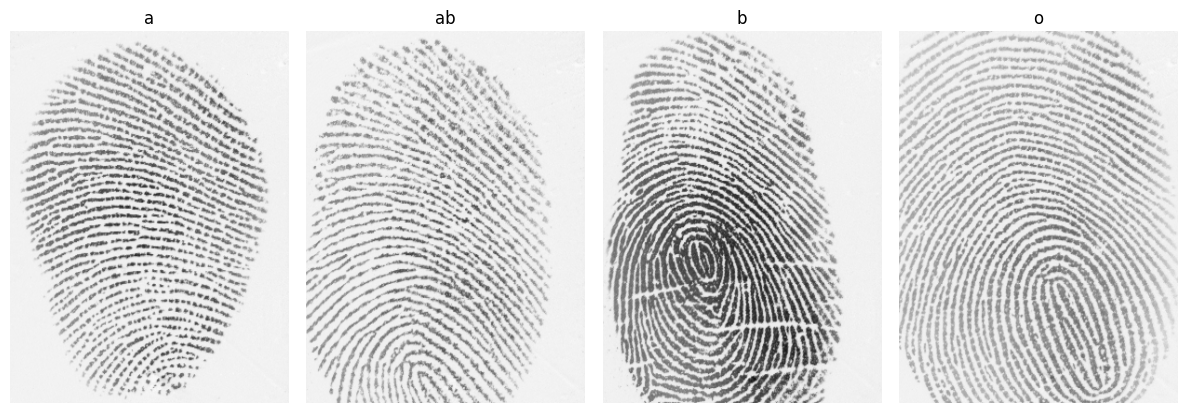

In [7]:
# Call the function to display dataset information
display_dataset_info(data_dir)

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values (VERY IMPORTANT!)
    validation_split=0.1,  # 80% train, 20% validation
    rotation_range=8,  # Rotate images up to 10 degrees
    #height_shift_range=0.1,  # Shift height by 10%
    #zoom_range=0.1,  # Zoom in/out by 10%
    #shear_range=0.1,  # Apply slight shearing (optional)
    horizontal_flip=True,  # Flip images horizontally
)


In [9]:
# Load the training data
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="training"
)

Found 615 images belonging to 4 classes.


In [14]:
# Validation data (NO AUGMENTATION, only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [15]:
# Load the validation data
val_gen = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    subset="validation"
)

Found 135 images belonging to 4 classes.


In [16]:
import numpy as np
from collections import Counter

# Assuming you've already created train_gen and val_gen
label_map = train_gen.class_indices  # e.g., {'a': 0, 'ab': 1, 'b': 2, 'o': 3}
inv_label_map = {v: k for k, v in label_map.items()}  # reverse lookup

# Count training labels
train_counts = Counter(train_gen.classes)
print("Training samples per class:")
for label_idx, count in train_counts.items():
    print(f"{inv_label_map[label_idx]}: {count}")

# Count validation labels
val_counts = Counter(val_gen.classes)
print("\nValidation samples per class:")
for label_idx, count in val_counts.items():
    print(f"{inv_label_map[label_idx]}: {count}")


Training samples per class:
a: 137
ab: 29
b: 188
o: 261

Validation samples per class:
a: 30
ab: 6
b: 41
o: 58


In [17]:
# Check the class indices mapping
print("Class Indices Mapping:", train_gen.class_indices)

Class Indices Mapping: {'a': 0, 'ab': 1, 'b': 2, 'o': 3}


In [18]:
print("Class Indices Mapping:", val_gen.class_indices)


Class Indices Mapping: {'a': 0, 'ab': 1, 'b': 2, 'o': 3}


In [19]:
# Compute class weights
class_labels = train_gen.classes  # Get class labels from the training generator
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

In [20]:
# Convert to dictionary for fitting the model
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weight Dictionary:", class_weight_dict)  # Print class weights for verification

Class Weight Dictionary: {0: 1.1222627737226278, 1: 5.301724137931035, 2: 0.8178191489361702, 3: 0.5890804597701149}


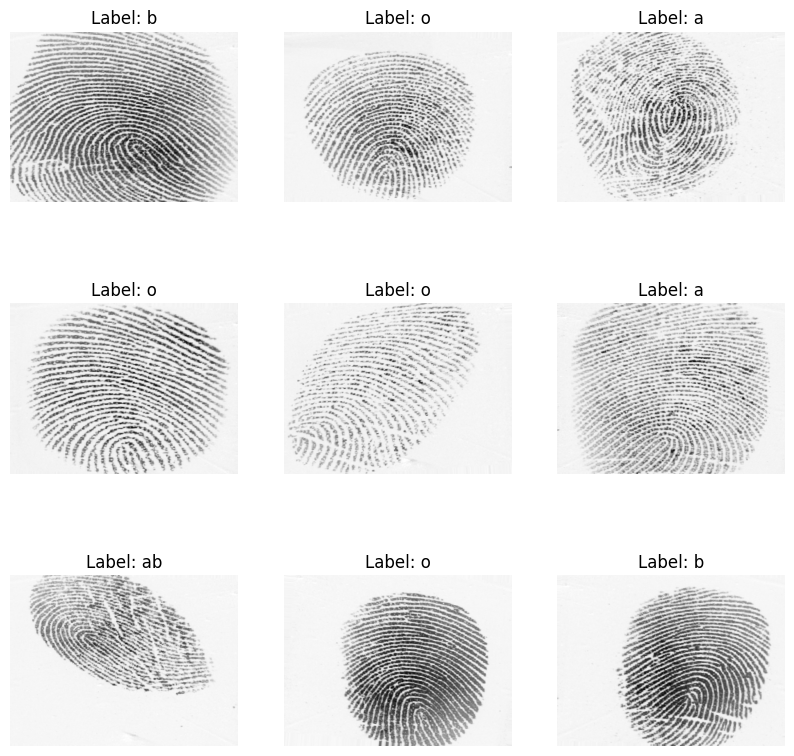

In [21]:
# Visualize Sample Images with Labels
images, labels = next(train_gen)  # Load a batch of images and labels
label_names = {v: k for k, v in train_gen.class_indices.items()}  # Reverse mapping for labels
decoded_labels = [label_names[np.argmax(label)] for label in labels]

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Label: {decoded_labels[i]}")
    plt.axis('off')
plt.show()

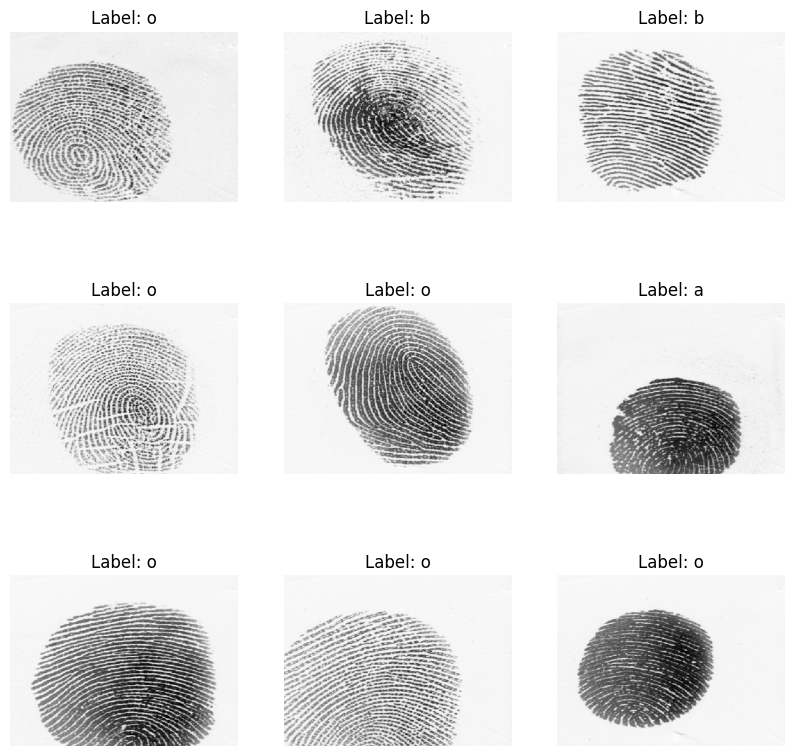

In [22]:
# Visualize Sample Images with Labels
images, labels = next(val_gen)  # Load a batch of images and labels
label_names = {v: k for k, v in train_gen.class_indices.items()}  # Reverse mapping for labels
decoded_labels = [label_names[np.argmax(label)] for label in labels]

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Label: {decoded_labels[i]}")
    plt.axis('off')
plt.show()

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build a Convolutional Neural Network (CNN) Model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(img_size[0], img_size[1], 1)),
    BatchNormalization(),  # Normalize activations after convolution
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation="relu"),
    BatchNormalization(),  # Normalizing dense layer activations
    Dropout(0.5),  # Regularization to prevent overfitting

    Dense(num_classes, activation="softmax")  # Output layer
])


c:\Users\Regino Balogo Jr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=["accuracy"]
)


In [30]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 398, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 298, 398, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 147, 197, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 96, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 215040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    27,525,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,619,844 (105.36 MB)

 Trainable params: 27,619,140 (105.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6          # Lower bound on the learning rate
)

In [33]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

In [ ]:
# Train the model
epochs = 30  # Adjust based on your needs
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[reduce_lr, early_stopping],  # Include callbacks
    class_weight=class_weight_dict,  # APPLY class weights here
    verbose=1
)

c:\Users\Regino Balogo Jr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.2794 - loss: 0.4715 - val_accuracy: 0.4296 - val_loss: 2.2983 - learning_rate: 0.0010
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.3442 - loss: 0.2629 - val_accuracy: 0.4296 - val_loss: 2.2983 - learning_rate: 0.0010
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 274s 7s/step - accuracy: 0.3443 - loss: 0.2636 - val_accuracy: 0.4296 - val_loss: 2.2983 - learning_rate: 0.0010
Epoch 4/30
22/39 ━━━━━━━━━━━━━━━━━━━━ 1:17 5s/step - accuracy: 0.3779 - loss: 0.2403

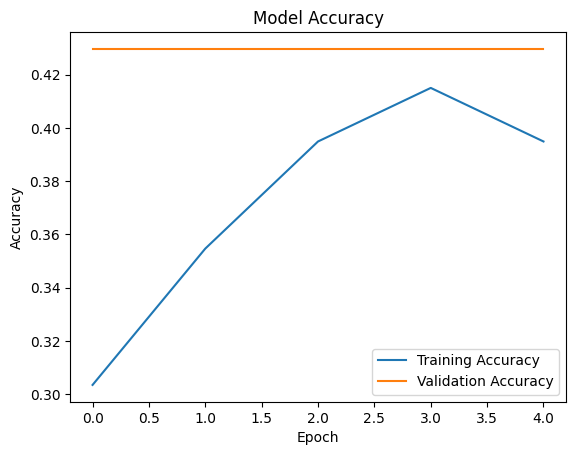

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

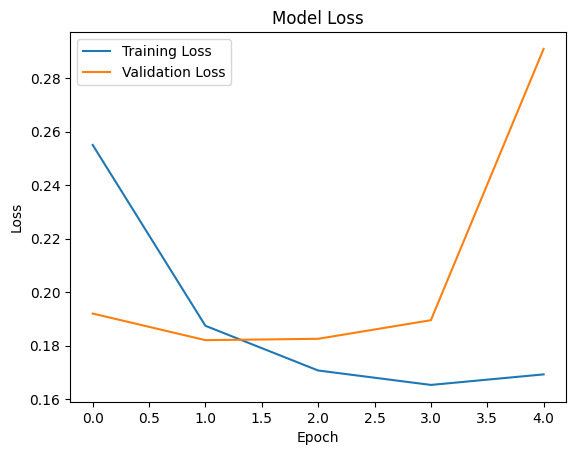

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - accuracy: 0.4361 - loss: 0.1805
Validation Accuracy: 0.4296
Validation Loss: 0.1821


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on val_gen
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print report
target_names = ['a', 'ab', 'b', 'o']
print(classification_report(y_true, y_pred_classes, target_names=target_names))


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step
              precision    recall  f1-score   support

           a       0.00      0.00      0.00        30
          ab       0.00      0.00      0.00         6
           b       0.00      0.00      0.00        41
           o       0.43      1.00      0.60        58

    accuracy                           0.43       135
   macro avg       0.11      0.25      0.15       135
weighted avg       0.18      0.43      0.26       135



c:\Users\Regino Balogo Jr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Regino Balogo Jr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Regino Balogo Jr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1 Score: 0.3333


c:\Users\Regino Balogo Jr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


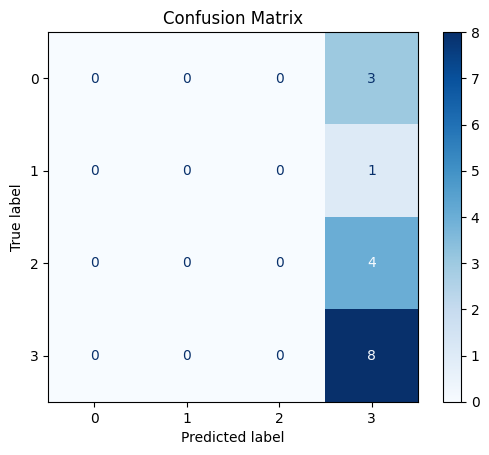

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get a batch from val_gen (just like you did for visualizing the images)
images, labels = next(val_gen)  # Load a batch of images and labels

# If it's a multi-class classification problem, get the predicted class indices
y_pred = model.predict(images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# If your labels are one-hot encoded, convert them to class indices
y_true = np.argmax(labels, axis=1)  # Convert one-hot labels to class indices

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')  # Use 'weighted' for imbalanced classes
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#model.save("improved.h5")